# Testing classifier

This script can be used to test the classifier against any input file previously generated.

In this case, we will use test set for our original IMDB dataset (on which we trained the model).

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os

# Loading test data

In [17]:
#Replace imdb_test_data.csv with the correct logit file
df_test = pd.read_csv("../Input data/imdb_test_data.csv", index_col=0)
df_test.shape

(682, 514)

In [18]:
if len(df_test)>500:
    df_test = df_test.sample(n=500, random_state=11)

In [19]:
y_test = df_test['y_label'].values
x_test = df_test.drop(columns=['y_label', 'sentence']).values

In [20]:
df_test['sentence'].head(5)

202    This movie literally had me rolling on the flo...
158    This show is the uncollectible show ever! Norr...
329    This is the best movie ever, but that is my op...
453    Straight to video and with good reason. Its li...
180    unity attended the premier last night. The mov...
Name: sentence, dtype: object

# Model and prediction

Load model and make predictions

In [21]:
import pickle

model = pickle.load(open('../imdb_classifier.pickle', "rb"))

In [22]:
predictions_raw = model.predict_proba(x_test)

In [23]:
predictions_raw[:3]

array([[0.57245183, 0.42754814],
       [0.01826733, 0.98173267],
       [0.9970494 , 0.00295064]], dtype=float32)

In [24]:
predictions_raw = predictions_raw[:,1]

In [25]:
predictions = predictions_raw.round()

In [26]:
df_test['y_hat'] = predictions
df_test['y_prob'] = predictions_raw
df_test['y'] = y_test

# Metrics and errors

Analyze the results

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[222,  26],
       [ 12, 240]])

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions, digits=3))

              precision    recall  f1-score   support

         0.0      0.949     0.895     0.921       248
         1.0      0.902     0.952     0.927       252

    accuracy                          0.924       500
   macro avg      0.925     0.924     0.924       500
weighted avg      0.925     0.924     0.924       500



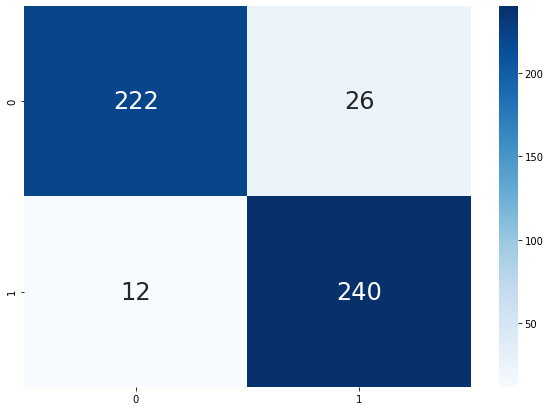

In [29]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap='Blues', fmt='g',  annot_kws={"fontsize":24})

# Shifting cutoff

We tried different values for the decision cutoff value to see whether we could further increase adversarial recall.

In [31]:
new_y_hat = np.where(predictions_raw>0.4, 1, 0)

In [32]:
new_y_hat[:10]

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 1])

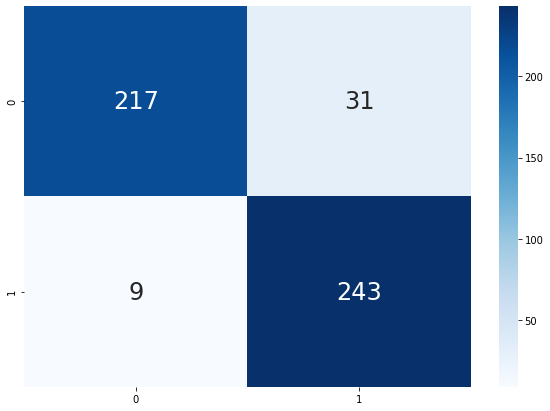

In [33]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_test, new_y_hat), annot=True, cmap='Blues', fmt='g',  annot_kws={"fontsize":24})

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, new_y_hat, digits=3))

              precision    recall  f1-score   support

         0.0      0.960     0.875     0.916       248
         1.0      0.887     0.964     0.924       252

    accuracy                          0.920       500
   macro avg      0.924     0.920     0.920       500
weighted avg      0.923     0.920     0.920       500



### 0.3

In [35]:
new_y_hat = np.where(predictions_raw>0.3, 1, 0)

In [36]:
new_y_hat[:10]

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 1])

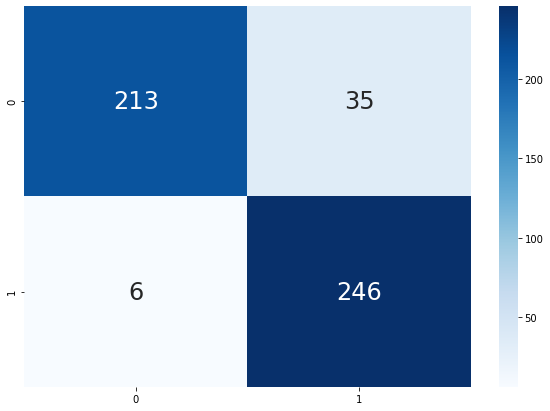

In [37]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_test, new_y_hat), annot=True, cmap='Blues', fmt='g',  annot_kws={"fontsize":24})

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, new_y_hat, digits=3))

              precision    recall  f1-score   support

         0.0      0.973     0.859     0.912       248
         1.0      0.875     0.976     0.923       252

    accuracy                          0.918       500
   macro avg      0.924     0.918     0.918       500
weighted avg      0.924     0.918     0.918       500



### 0.15

In [39]:
new_y_hat = np.where(predictions_raw>0.15, 1, 0)

In [40]:
new_y_hat[:10]

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 1])

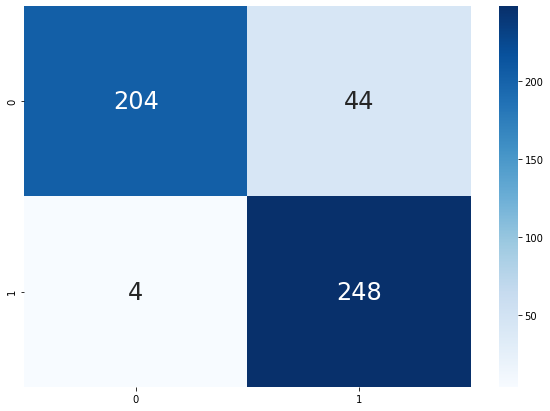

In [41]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(confusion_matrix(y_test, new_y_hat), annot=True, cmap='Blues', fmt='g',  annot_kws={"fontsize":24})

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, new_y_hat, digits=3))

              precision    recall  f1-score   support

         0.0      0.981     0.823     0.895       248
         1.0      0.849     0.984     0.912       252

    accuracy                          0.904       500
   macro avg      0.915     0.903     0.903       500
weighted avg      0.915     0.904     0.903       500



# Density chart

In [43]:
import plotly.figure_factory as ff
import numpy as np

# Plot the probability density chart
probability_dens = pd.DataFrame({'prob': predictions_raw, 'y': y_test})

x1 = probability_dens[probability_dens["y"]==1]['prob'].values
x2 = probability_dens[probability_dens["y"]==0]['prob'].values

hist_data = [x1, x2]

group_labels = ['Adversarial', 'Original']
colors = ['#C04000', '#228B22']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors, show_rug=False)

# Add title
fig.update_layout(legend=dict(
                    orientation="h",
                    yanchor="middle",
                    y=1.1,
                    xanchor="right",
                    x=1
                ))

fig.update_yaxes(visible=False, showticklabels=False)
fig.show()